 Please upload your image (e.g., bird.jpg)


Saving Scarlet-macaw-ara-macao.jpg to Scarlet-macaw-ara-macao.jpg

 Image uploaded successfully: Scarlet-macaw-ara-macao.jpg


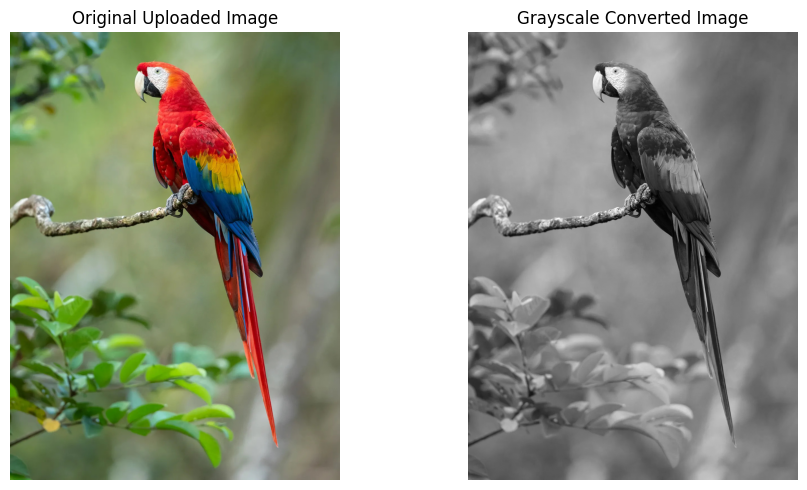

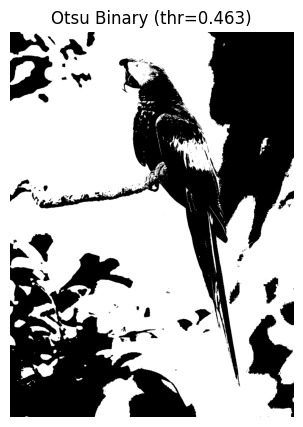

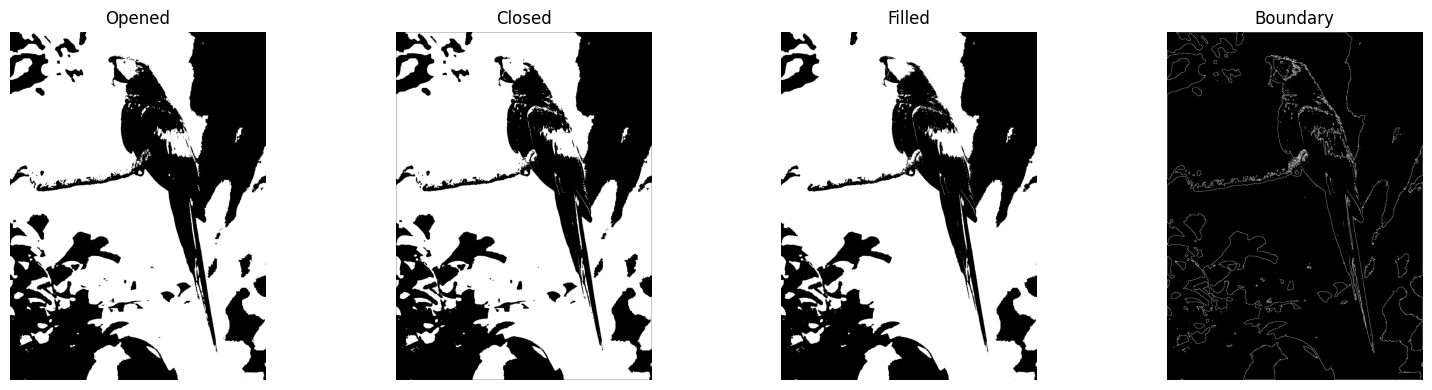


Detected 841 segmented regions

 Label  Area(px^2)  Perimeter(px)      Centroid(y,x)  Eccentricity
     1     1111875   20178.782674   (783.84, 561.14)        0.8218
     2           1       0.000000       (0.0, 826.0)        0.0000
     3           1       0.000000      (11.0, 111.0)        0.0000
     4           1       0.000000      (15.0, 343.0)        0.0000
     5           2       0.000000      (39.0, 109.5)        1.0000
     6          37      26.863961    (51.92, 887.32)        0.9044
     7          18      15.828427   (115.67, 496.22)        0.9799
     8           4       4.621320    (117.25, 503.0)        0.7906
     9           2       0.000000     (117.0, 510.5)        1.0000
    10        5295     353.119841    (165.73, 52.83)        0.8889
    11           2       0.000000     (120.0, 497.5)        1.0000
    12           1       0.000000     (122.0, 492.0)        0.0000
    13           2       0.000000     (140.0, 594.5)        1.0000
    14           2       0.00

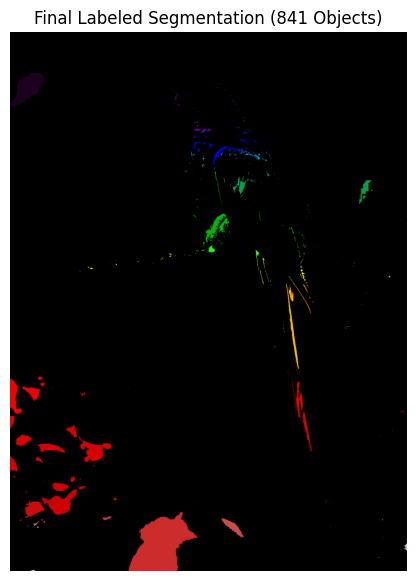

In [1]:
# =========================
# DIP DA2 — Segmentation & Morphology
# =========================

#  Step 1 — Install required libraries
!pip -q install scikit-image

import os, numpy as np, matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import io, color, measure
import pandas as pd
from google.colab import files

#  Step 2 — Create output folder
OUT_DIR = "seg_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

#  Step 3 — Upload any image you want (bird, animal, etc.)
print(" Please upload your image (e.g., bird.jpg)")
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
print(f"\n Image uploaded successfully: {img_path}")

#  Step 4 — Read and convert to grayscale
img_color = io.imread(img_path)

# Handle both color and grayscale inputs
if img_color.ndim == 3:
    img = color.rgb2gray(img_color)
else:
    img = img_color

img = img.astype(np.float32)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Show original and grayscale images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_color)
plt.title("Original Uploaded Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.title("Grayscale Converted Image")
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "00_input_uploaded.png"), dpi=150, bbox_inches='tight')
plt.show()

#  Step 5 — Otsu Thresholding
def otsu_threshold(image):
    hist, _ = np.histogram(image.ravel(), bins=256, range=(0,1))
    hist = hist.astype(np.float64)
    prob = hist / hist.sum()
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]
    num = (mu_t * omega - mu)**2
    den = omega * (1 - omega)
    sigma_b2 = np.zeros_like(num)
    valid = den > 0
    sigma_b2[valid] = num[valid] / den[valid]
    t = np.argmax(sigma_b2)
    return (t + 0.5) / 256.0

thr_otsu = otsu_threshold(img)
bw_otsu = (img >= thr_otsu).astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(bw_otsu, cmap='gray')
plt.title(f"Otsu Binary (thr={thr_otsu:.3f})")
plt.axis('off')
plt.show()

#  Step 6 — Morphological operations
S3 = np.ones((3,3), dtype=np.uint8)
opened = ndi.binary_opening(bw_otsu, structure=S3)
closed = ndi.binary_closing(bw_otsu, structure=S3)
filled = ndi.binary_fill_holes(bw_otsu).astype(np.uint8)
boundary = (bw_otsu - ndi.binary_erosion(bw_otsu, structure=S3).astype(np.uint8))

# Show morphology results
fig, axes = plt.subplots(1, 4, figsize=(16,4))
titles = ["Opened", "Closed", "Filled", "Boundary"]
images = [opened, closed, filled, boundary]
for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

#  Step 7 — Connected Components & Feature Extraction
lab, nlab = ndi.label(filled)
props = measure.regionprops(lab)

print(f"\nDetected {len(props)} segmented regions\n")
rows = []
for r in props:
    rows.append({
        "Label": r.label,
        "Area(px^2)": int(r.area),
        "Perimeter(px)": float(r.perimeter),
        "Centroid(y,x)": tuple(round(v,2) for v in r.centroid),
        "Eccentricity": float(round(r.eccentricity, 4))
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))

# Save CSV
csv_path = os.path.join(OUT_DIR, "uploaded_image_features.csv")
df.to_csv(csv_path, index=False)
print(f"\n Feature table saved to: {csv_path}")

#  Step 8 — Visualize labeled regions
plt.figure(figsize=(7,7))
plt.imshow(lab, cmap='nipy_spectral')
plt.title(f"Final Labeled Segmentation ({nlab} Objects)")
plt.axis('off')
plt.show()
